In [1]:
import pandas as pd
import sqldf
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np

In [2]:
import nltk
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor

In [6]:
data = pd.read_csv('dataset.csv')

In [7]:
# ne pas reccupérer les lignes à quantité négative
data = data[data['Quantity']>=0]

In [16]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,day,month,year
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850,United Kingdom,1,12,2010
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850,United Kingdom,1,12,2010
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850,United Kingdom,1,12,2010
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850,United Kingdom,1,12,2010
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850,United Kingdom,1,12,2010


#### preprocessing

In [9]:
#Remplacer les valeurs vides par 0 pour les colonnes de type entier ou float
data[['InvoiceNo', 'Quantity', 'UnitPrice', 'CustomerID']]=data[['InvoiceNo', 'Quantity', 'UnitPrice', 'CustomerID']].fillna(0)

In [10]:
# Mettre la date au bon format...
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'], errors='coerce')
data['InvoiceDate']= data['InvoiceDate'].dt.strftime("%Y-%m-%d")

In [11]:
#Mettre le bon type pour le colonnes de type int, float
data['UnitPrice'] = data['UnitPrice'].apply(lambda x: x.replace(',', '.'))
data['UnitPrice']=data['UnitPrice'].astype(float)
data['CustomerID']=data['CustomerID'].astype(int)

In [12]:
#Ajout des colonnes year, month, day pour faciliter le filtre sur le mois, l'année ou le jour
data['day'] = pd.DatetimeIndex(data['InvoiceDate']).day
data['month'] = pd.DatetimeIndex(data['InvoiceDate']).month
data['year'] = pd.DatetimeIndex(data['InvoiceDate']).year

In [13]:
# Suppression des doublons dans la table
data = data.drop_duplicates()

In [17]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,day,month,year
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850,United Kingdom,1,12,2010
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850,United Kingdom,1,12,2010
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850,United Kingdom,1,12,2010
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850,United Kingdom,1,12,2010
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850,United Kingdom,1,12,2010


### TP

<H3 style="color:red"> Question 1  -  Volume </H3>

In [18]:
query_customer = """
    SELECT CustomerID, InvoiceNo, avg(Quantity) as avg_number_products
    FROM data
    group by CustomerID, InvoiceNo
"""

In [19]:
df_customer_mean = sqldf.run(query_customer)

 ***
 Pour chaque client la moyenne de produits achetés, grouper par l'id de ses différentes dépense

In [20]:
df_customer_mean

,CustomerID,InvoiceNo,avg_number_products
0,0,536414,56.000000
1,0,536544,2.292220
2,0,536545,1.000000
3,0,536546,1.000000
4,0,536547,1.000000
...,...,...,...
20723,18283,579673,2.640000
20724,18283,580872,2.840000
20725,18287,554065,16.827586
20726,18287,570715,26.052632


In [21]:
final_result = df_customer_mean.groupby('CustomerID').mean().reset_index()

***
__la moyenne générale de toutes les dépenses pour chacun des clients (que les top 20 dans le graphe)__

In [22]:
final_result.head()

,CustomerID,avg_number_products
0,0,28.121002
1,12346,74215.000000
2,12347,13.799245
3,12348,75.016176
4,12349,8.643836


In [27]:
display = final_result.sort_values('avg_number_products',ascending=False).head(20)

<AxesSubplot:xlabel='CustomerID'>

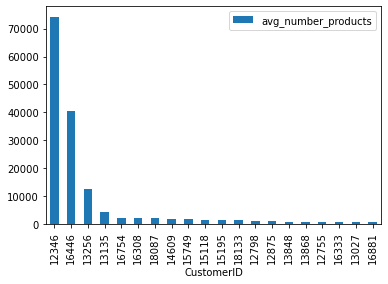

In [28]:
display.plot(kind='bar', x='CustomerID', y='avg_number_products')

In [29]:
#Création d'un dataframe vide qui contiendra le resultat final (Pays, moyenne, mediane)
volume = pd.DataFrame()

In [30]:
# On rajoute dans le df la première colonne qui correspond à la moyenne tout en groupant sur les pays
volume['average'] = data.groupby('Country')['Quantity'].mean()

In [31]:
# On rajoute dans le df la deuxième colonne qui correspond à la médiane tout en groupant sur les pays
volume['median'] = data.groupby('Country')['Quantity'].apply(np.median)

In [32]:
#Pour éviter que l'index soit le pays
volume= volume.reset_index()

In [44]:
# affichage du tableau finalement...
volume.head()

,Country,average,median
0,Australia,71.114020,32.0
1,Austria,12.263819,10.0
2,Bahrain,17.444444,6.0
3,Belgium,11.441162,10.0
4,Brazil,11.125000,10.0


*** 
__Affichage du graphe en prenant que 15 pays__

In [40]:
display_volum = volume.head(15)

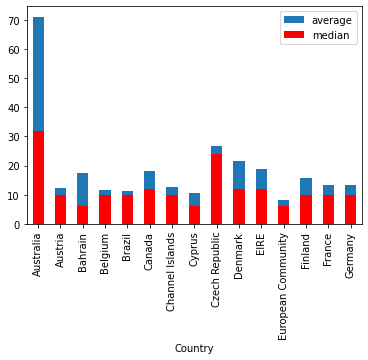

In [41]:
ax = plt.gca()

display_volum.plot(kind='bar',x='Country',y='average',ax=ax)
display_volum.plot(kind='bar',x='Country',y='median', color='red', ax=ax)

plt.show()

<H3 style="color:red"> Question 2  - Montant</H3>

In [42]:
# Requête SQL pour reccupérer pour chaque client la moyenne du montant dépensé par numéro dépense
query_customer_UnitPrice = """
    SELECT CustomerID, InvoiceNo, avg(UnitPrice*Quantity) as mean
    FROM data
    group by CustomerID, InvoiceNo
"""

In [43]:
df_customer_mean_price = sqldf.run(query_customer_UnitPrice)

 ***
 Pour chaque client la moyenne du montant dépensé, grouper par l'id su client de ses différentes dépense

In [60]:
df_customer_mean_price.head()

,CustomerID,InvoiceNo,mean
0,0,536414,0.000000
1,0,536544,10.476546
2,0,536545,0.000000
3,0,536546,0.000000
4,0,536547,0.000000


***
__la moyenne générale du montant dépensé de toutes les dépenses pour chacun des clients (que les top 20 dans le graphe)__

In [45]:
# calcul de la moyenne globale
customer_amount = df_customer_mean_price.groupby('CustomerID').mean().reset_index()

In [46]:
customer_amount.head()

,CustomerID,mean
0,0,17.428182
1,12346,77183.600000
2,12347,23.096997
3,12348,66.789412
4,12349,24.076027


In [47]:
display_customer_amount = customer_amount.sort_values('mean',ascending=False).head(20)

<AxesSubplot:xlabel='CustomerID'>

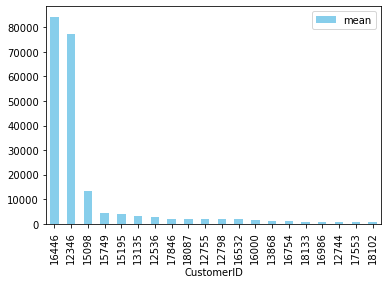

In [51]:
display_customer_amount.plot(kind='bar', x='CustomerID', y='mean', color='skyblue')

<h5 style="color: cadetblue">  montant moyen et le montant médian d’un panier client, par pays</h5>

In [52]:
# copie de la table de base dans une table de "test"
data_test = data.copy(deep=True)

In [53]:
# création d'un dataframe vide qui stockera le resultat final
montant = pd.DataFrame()

In [54]:
# pour chaque ligne on calcule le montant dépensé == prix unitaire * quantité
data_test['cart_amount'] = data_test[['Quantity', 'UnitPrice']].apply(lambda x : (x['Quantity'] * x['UnitPrice']), 1)

In [55]:
# ajout de la colonne average qui correspond à la moyenne dépensé en groupant par pays<
montant['average'] = data_test.groupby('Country')['cart_amount'].mean()

In [56]:
# ajout de la colonne median qui correspond à la mediane du montant dépensé en groupant par pays<
montant['median'] = data_test.groupby('Country')['cart_amount'].apply(np.median)

In [57]:
montant= montant.reset_index()

In [58]:
montant

,Country,average,median
0,Australia,116.937340,66.00
1,Austria,25.624824,17.17
2,Bahrain,41.896667,25.50
3,Belgium,20.283772,16.60
4,Brazil,35.737500,19.65
5,Canada,24.280662,16.50
6,Channel Islands,27.363507,17.70
7,Cyprus,22.392786,16.50
8,Czech Republic,33.069600,31.20
9,Denmark,49.882474,23.40


##### Affichage 

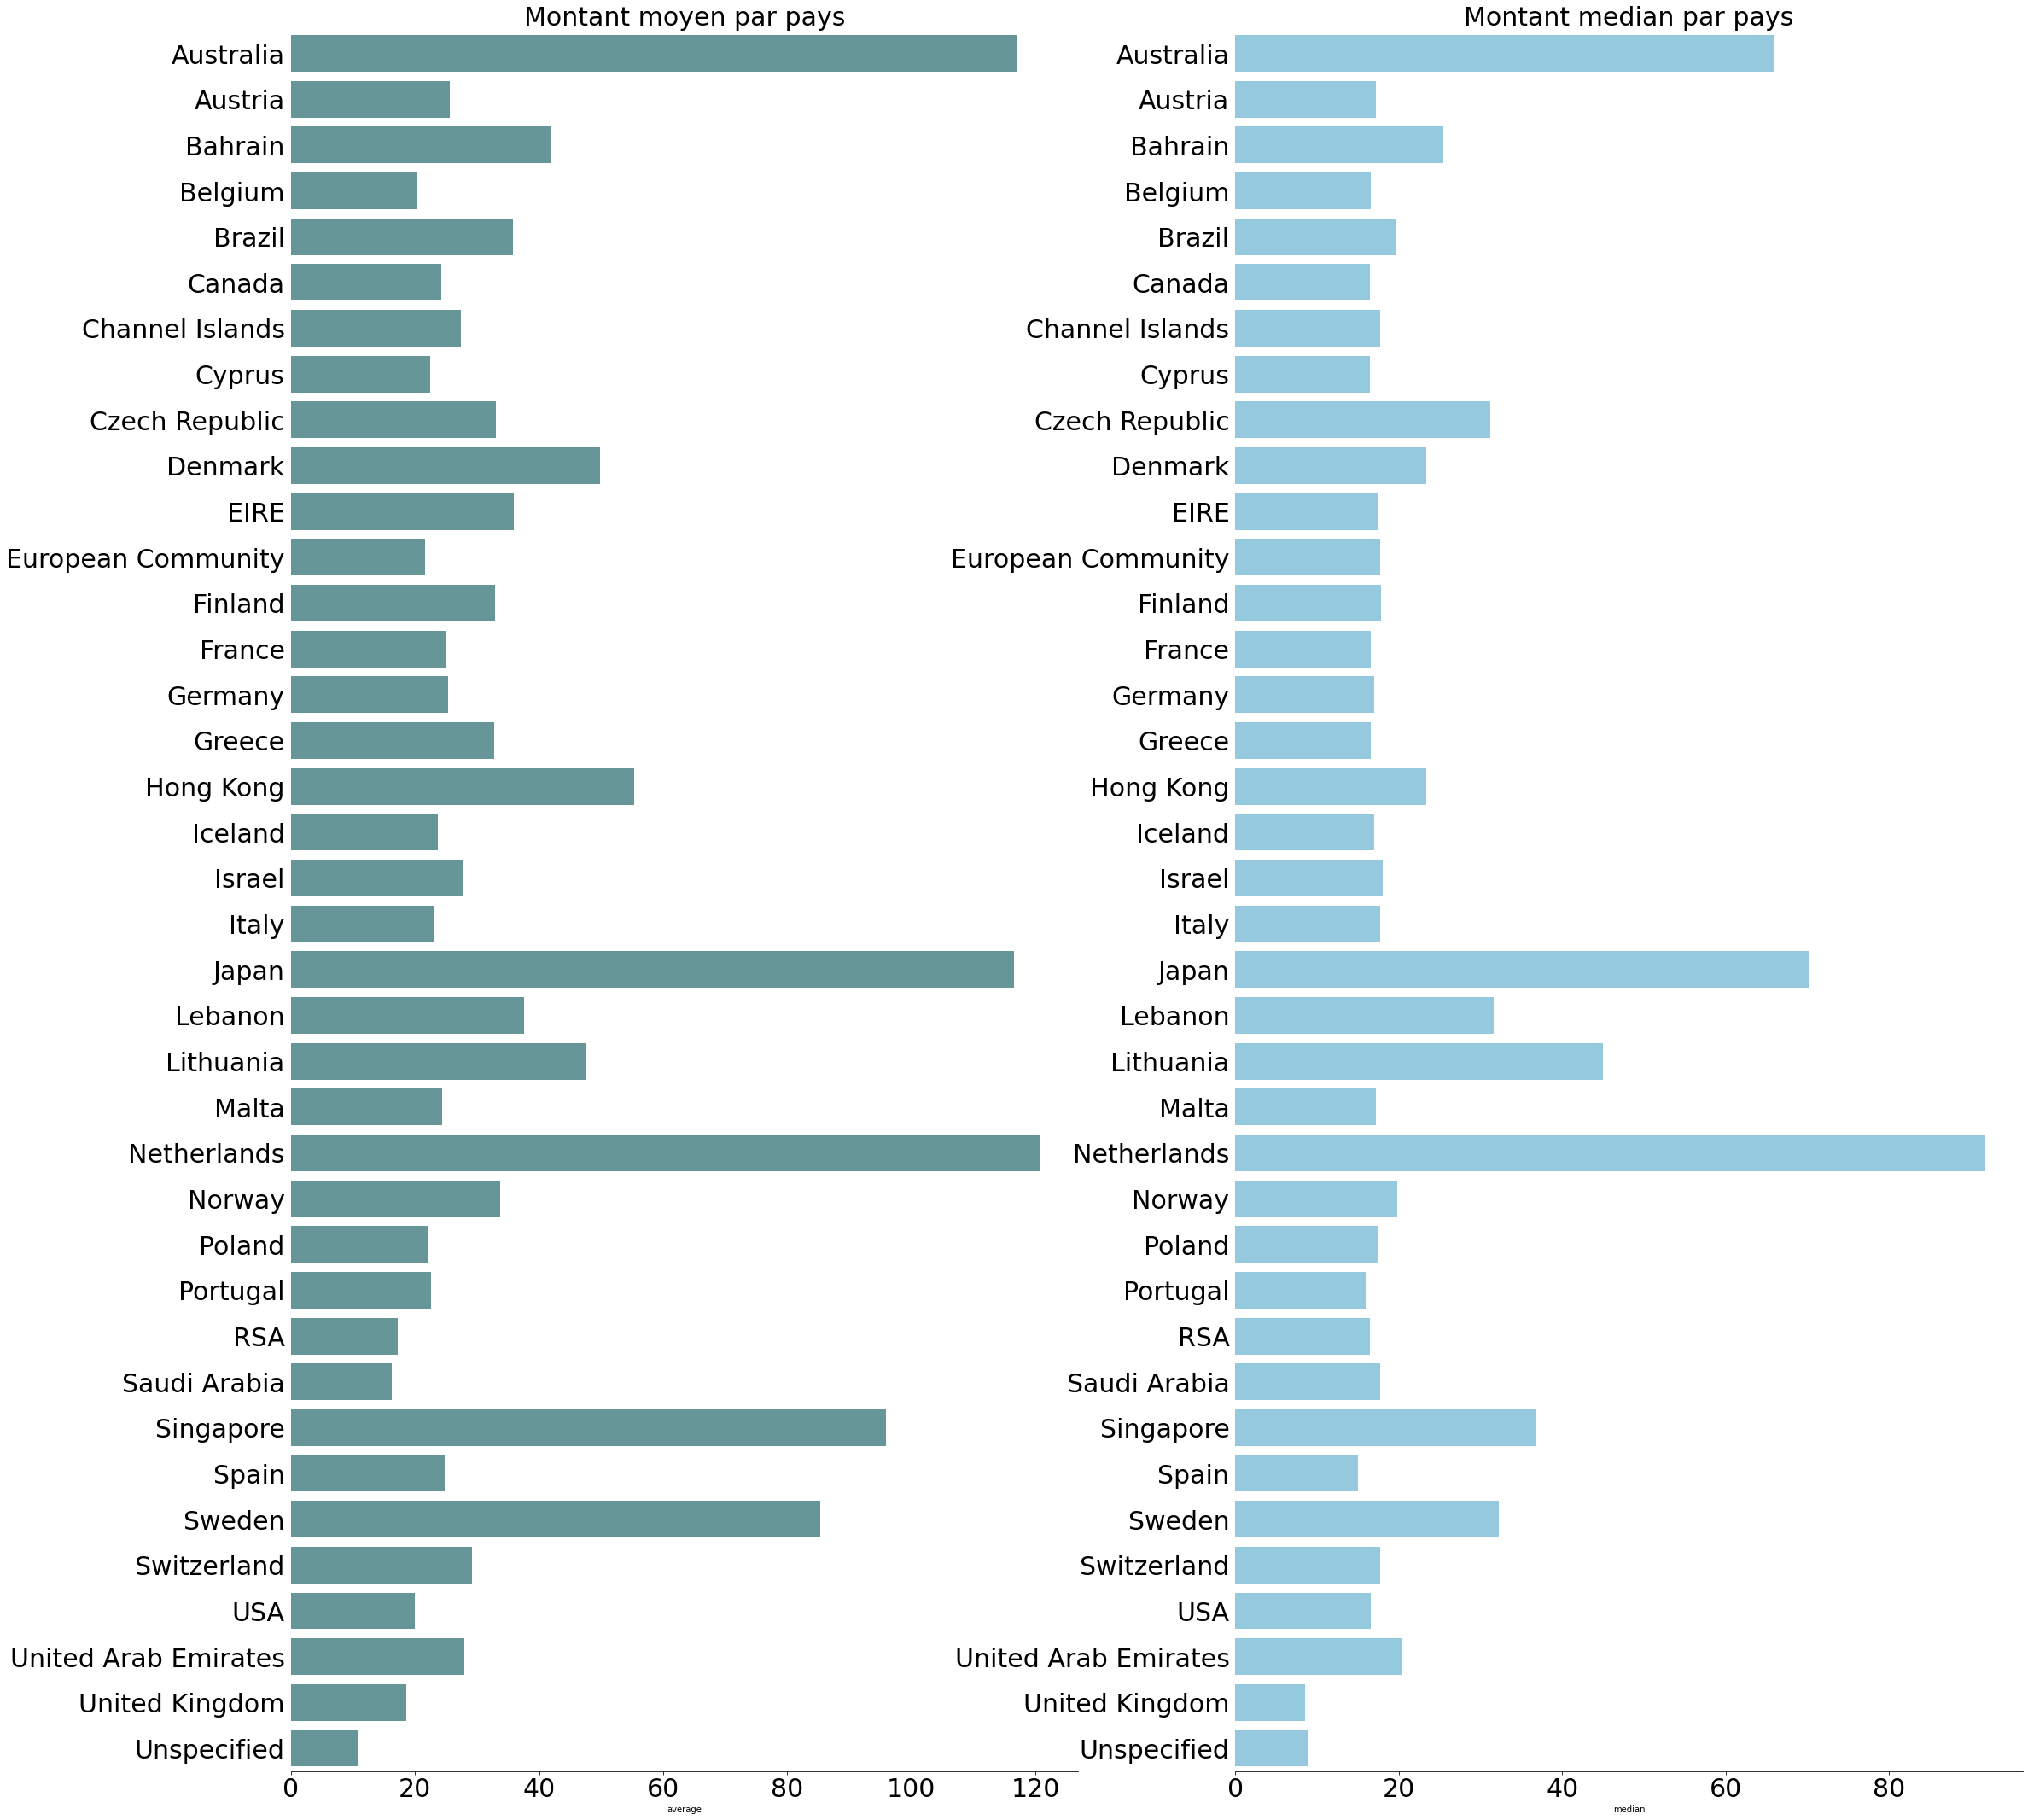

In [59]:
fig, ax = plt.subplots(figsize=(30,30))
fig.tight_layout(pad=5)

def plot_hor_bar(subplot, data):
    plt.subplot(1,2,subplot)
    if subplot==1:
        ax = sns.barplot(y='Country', x='average', data=data,
                     color='cadetblue')
        plt.title("Montant moyen par pays",
          fontsize=30)
    else : 
        ax = sns.barplot(y='Country', x='median', data=data,
                     color='skyblue')
        plt.title("Montant median par pays",
          fontsize=30)
    plt.xticks(fontsize=30)
    plt.ylabel(None)
    plt.yticks(fontsize=30)
    sns.despine(left=True)
    ax.grid(False)
    ax.tick_params(bottom=True, left=False)
    return None

plot_hor_bar(1, montant[['Country', 'average']])
plot_hor_bar(2, montant[['Country', 'median']])

plt.show()

<H3 style="color:red"> Question 3 - Volume </H3>

In [63]:
# Requête SQL pour calculer le cumul de quantité vendus pour chaque produit
top_5_products = """
    SELECT StockCode as code_produits, sum(Quantity) as total_vente
    FROM data
    where year=2011 and month between 1 and 3
    group by StockCode 
    order by total_vente desc
    limit 5
"""

In [64]:
df_top_5_products = sqldf.run(top_5_products)

> Top 5 des produits vendus au premier trimestre avec le total de ventes

In [65]:
df_top_5_products

,code_produits,total_vente
0,23166,74215
1,85099B,11109
2,21212,9477
3,85123A,9403
4,84077,8898


<h5 style="color: green">  top-5 produits les plus vendus durant le second
trimestre 2011</h5>

In [75]:
top_5_products_second_trimestre = """
    SELECT StockCode, sum(Quantity) as total_quantity
    FROM data
    where year=2011 and month between 4 and 6
    group by StockCode 
    order by total_quantity desc
    limit 5
"""

In [76]:
df_top_5_products_second_trimestre = sqldf.run(top_5_products_second_trimestre)

In [77]:
df_top_5_products_second_trimestre

,StockCode,total_quantity
0,23005,19402
1,84077,18462
2,85123A,15495
3,22197,10822
4,15036,9996


<H3 style="color:red"> Question 4 - Montant </H3>

<h5 style="color: green">  les 5 pays qui ont générés le plus gros chiffre d’affaire
pendant le premier trimestre 2011</h5>

In [20]:
CA_country = """
    SELECT Country, sum(Quantity * UnitPrice) as CA
    FROM data
    where year=2011 and month between 1 and 3
    group by Country 
    order by CA desc
"""

In [21]:
df_CA_country = sqldf.run(CA_country)

In [22]:
df_CA_country = df_CA_country.head(5)

In [23]:
df_CA_country

,Country,CA
0,United Kingdom,1748835.50
1,Netherlands,72119.36
2,EIRE,62541.99
3,Germany,42148.47
4,France,41227.78


<H3 style="color:red"> Question 5 - Montant moyen et du montant médian d’un panier client pour chacun de ces cinq pays </H3>

In [55]:
df = data[(data['Country'].isin(df_CA_country.Country)) & (data['year']==2011) & (data['month'].between(1,3))]

In [56]:
df['cart_amount'] = df[['Quantity', 'UnitPrice']].apply(lambda x : (x['Quantity'] * x['UnitPrice']), 1)

/var/folders/0j/l37t0qrj7994qvgj06z5ybww0000gq/T/ipykernel_10808/3385646775.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cart_amount'] = df[['Quantity', 'UnitPrice']].apply(lambda x : (x['Quantity'] * x['UnitPrice']), 1)


In [58]:
evol = pd.DataFrame()

In [59]:
evol['median'] = df.groupby(['Country', 'month'])['cart_amount'].apply(np.median)

In [60]:
evol['average'] = df.groupby(['Country', 'month'])['cart_amount'].mean()

In [61]:
evol = evol.reset_index()

In [62]:
evol_Australia = evol[evol['Country']=='Australia']

In [63]:
evol_EIRE = evol[evol['Country']=='EIRE']

In [64]:
evol_France = evol[evol['Country']=='France']

In [65]:
evol_Netherlands = evol[evol['Country']=='Netherlands']

In [66]:
evol_United_Kingdom = evol[evol['Country']=='United Kingdom']

In [91]:
evol

,Country,month,median,average
0,EIRE,1,23.40,117.205608
1,EIRE,2,15.70,33.740502
2,EIRE,3,17.00,45.330602
3,France,1,17.70,26.632844
4,France,2,15.90,20.171385
5,France,3,16.60,26.747445
6,Germany,1,15.30,21.018485
7,Germany,2,17.00,29.122457
8,Germany,3,16.50,24.197616
9,Netherlands,1,76.50,116.205939


> Affichage du graphe

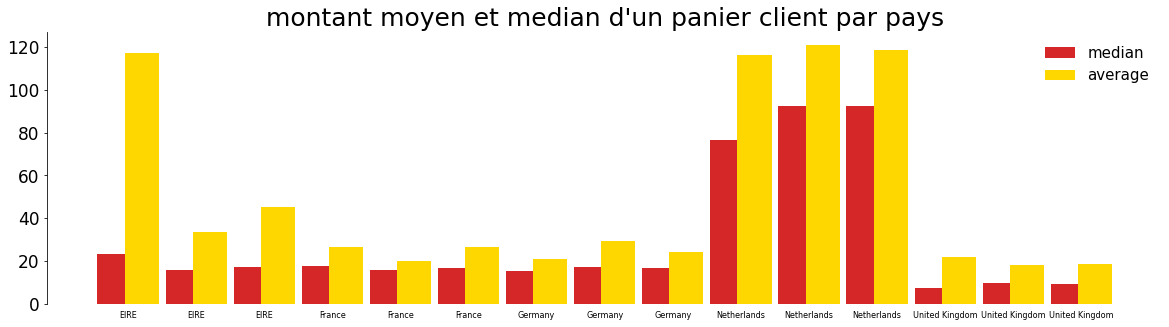

In [74]:
fig, ax = plt.subplots(figsize=(20,5))
x = np.arange(len(evol))
width = 0.5
plt.bar(x-0.2, evol['median'],
        width, color='tab:red', label='median')
plt.bar(x+0.2, evol['average'],
        width, color='gold', label='average')
plt.title('montant moyen et median d\'un panier client par pays', fontsize=25)
plt.xlabel(None)
plt.xticks(evol.index, evol['Country'], fontsize=8)
plt.yticks(fontsize=17)
sns.despine(bottom=True)
ax.grid(False)
ax.tick_params(bottom=False, left=True)
plt.legend(frameon=False, fontsize=15)
plt.show()

<H3 style="color:red"> Question 6 -  à quelle fréquence dépensent les 100 plus gros clients du RoyaumeUni </H3>

In [31]:
united_kingdom = """
    SELECT CustomerID, sum(Quantity) quantity, sum(Quantity*UnitPrice) price
    FROM data
    where Country='United Kingdom'
    group by CustomerID 
    order by quantity desc
    limit 100
"""

In [32]:
united_kingdom = sqldf.run(united_kingdom)

In [33]:
united_kingdom

,CustomerID,quantity,price
0,0,673126,1.969219e+06
1,16446,161992,3.369421e+05
2,12346,148430,1.543672e+05
3,17450,70937,2.014594e+05
4,17511,66086,9.399938e+04
...,...,...,...
95,15615,5523,1.043944e+04
96,13316,5509,5.895170e+03
97,13001,5498,9.806870e+03
98,16705,5494,1.412385e+04


In [92]:
print("les 100 plus gros client du Royaume unis achètent en moyenne " + '\033[1m' + str(united_kingdom.quantity.mean()) + '\033[0m' + " produits "
     + "pour en moyenne " + '\033[1m' + str(int(united_kingdom.price.mean())) + "$")

les 100 plus gros client du Royaume unis achètent en moyenne 24999.3 produits pour en moyenne 50932$


<H2 style="color: black; text-align:center"> Modèle prédictive</H2>

In [33]:
data_test = data.copy(deep=True)

In [34]:
data_test['cart_amount'] = data_test[['Quantity', 'UnitPrice']].apply(lambda x : (x['Quantity'] * x['UnitPrice']), 1)

In [35]:
data_model = data_test[['InvoiceDate', 'UnitPrice', 'Quantity', 'cart_amount', 'Country', 'year', 'month', 'day']]

In [36]:
data_model.head()

,InvoiceDate,UnitPrice,Quantity,cart_amount,Country,year,month,day
0,2010-12-01,2.55,6,15.30,United Kingdom,2010,12,1
1,2010-12-01,3.39,6,20.34,United Kingdom,2010,12,1
2,2010-12-01,2.75,8,22.00,United Kingdom,2010,12,1
3,2010-12-01,3.39,6,20.34,United Kingdom,2010,12,1
4,2010-12-01,3.39,6,20.34,United Kingdom,2010,12,1


In [37]:
data_model = data_model.groupby(['InvoiceDate', 'year', 'month', 'day']).agg({'cart_amount':'sum'}).reset_index()

In [38]:
data_model

,InvoiceDate,year,month,day,cart_amount
0,2010-12-01,2010,12,1,59102.02
1,2010-12-02,2010,12,2,49170.52
2,2010-12-03,2010,12,3,48221.88
3,2010-12-05,2010,12,5,31755.63
4,2010-12-06,2010,12,6,55594.43
...,...,...,...,...,...
300,2011-12-05,2011,12,5,119611.48
301,2011-12-06,2011,12,6,59008.27
302,2011-12-07,2011,12,7,75678.49
303,2011-12-08,2011,12,8,83448.77


### Entrainement du modèle et testing

In [39]:
x = data_model[['year', 'month', 'day']]
y = data_model['cart_amount']

In [40]:
X_train, X_test, Y_train, Y_test = train_test_split(x,y,test_size=0.2)

In [41]:
print("X_train = " , X_train.shape)
print("X_test = " , X_test.shape)
print("Y_train = " , Y_train.shape)
print("Y_test = " , Y_test.shape)

X_train =  (244, 3)
X_test =  (61, 3)
Y_train =  (244,)
Y_test =  (61,)


In [42]:
model = RandomForestRegressor()

In [43]:
rf = model.fit(X_train, Y_train)

In [44]:
predict = rf.predict(X_test)

In [45]:
rf.score(X_train, Y_train)

0.8410144295378671

### Prédiction

In [46]:
model = RandomForestRegressor()

In [47]:
rf = model.fit(x, y)

In [48]:
# Pour avoir les jours manquants du mois de décembre 2011 du 10 au 31 mais aussi la journée du 3
list_day = [i for i in range(10,32)]
list_day.append(3)

In [49]:
data_december = pd.DataFrame.from_dict({'year': [2011 for i in range(len(list_day))],
                'month': [12 for i in range(len(list_day))],
                'day': list_day
                })

In [51]:
data_december_final = data_december.copy(deep=True)

In [52]:
data_december_final['cart_amount']=rf.predict(data_december)

In [53]:
data_december_final.head()

,year,month,day,cart_amount
0,2011,12,10,209503.4164
1,2011,12,11,177636.3334
2,2011,12,12,136861.5778
3,2011,12,13,138941.5872
4,2011,12,14,156885.4192


In [54]:
data_model_december = data_model[(data_model['year']==2011) & (data_model['month']==12)][['year', 'month', 'day','cart_amount']]

In [55]:
data_december_final = pd.concat([data_model_december, data_december_final], ignore_index=True)

In [56]:
data_december_final.sort_values('day')

,year,month,day,cart_amount
0,2011,12,1,52854.9300
1,2011,12,2,58054.4900
30,2011,12,3,55327.0183
2,2011,12,4,24533.1200
3,2011,12,5,119611.4800
4,2011,12,6,59008.2700
5,2011,12,7,75678.4900
6,2011,12,8,83448.7700
7,2011,12,9,369690.0500
8,2011,12,10,209503.4164


In [57]:
print("le CA en décembre 2011 sera de : " + '\033[1m' +  str(data_december_final.cart_amount.sum()))

le CA en décembre 2011 sera de : 3669351.9786000014


<h2 style="color: green">  Achat réalisé en france en Décembre 2011</h2>

In [160]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,year,month,day,cart_amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850,United Kingdom,2010,12,1,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850,United Kingdom,2010,12,1,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850,United Kingdom,2010,12,1,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850,United Kingdom,2010,12,1,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850,United Kingdom,2010,12,1,20.34


In [212]:
data_purchase = data[['InvoiceNo', 'CustomerID', 'InvoiceDate', 'UnitPrice', 'Quantity', 'Country', 'year', 'month', 'day']]

In [213]:
data_purchase = data_purchase.groupby(['Country', 'CustomerID', 'InvoiceDate', 'year', 'month', 'day']).agg({'InvoiceNo':'count'})

In [214]:
data_purchase = data_purchase.reset_index()

In [215]:
data_purchase = data_purchase.rename({'InvoiceNo': 'purchase_count'}, axis=1)  # new method

In [216]:
data_purchase

,Country,CustomerID,InvoiceDate,year,month,day,purchase_count
0,Australia,12386,2010-12-08,2010,12,8,8
1,Australia,12386,2011-01-06,2011,1,6,2
2,Australia,12388,2011-01-17,2011,1,17,19
3,Australia,12388,2011-02-07,2011,2,7,6
4,Australia,12388,2011-03-09,2011,3,9,10
...,...,...,...,...,...,...,...
19622,Unspecified,12743,2011-07-28,2011,7,28,131
19623,Unspecified,14265,2011-07-14,2011,7,14,15
19624,Unspecified,14265,2011-08-22,2011,8,22,16
19625,Unspecified,16320,2011-05-10,2011,5,10,47


In [217]:
x_puchase = data_purchase[['year', 'month', 'day']]
y_purchase = data_purchase['purchase_count']

In [218]:
rf_purchase = model.fit(x_puchase, y_purchase)

In [219]:
# Pour avoir les jours manquants du mois de décembre 2011 du 10 au 31 mais aussi la journée du 3
list_day_purchas = [i for i in range(10,32)]
list_day_purchas.append(3)

In [220]:
december_purchas = pd.DataFrame.from_dict({'year': [2011 for i in range(len(list_day_purchas))],
                'month': [12 for i in range(len(list_day_purchas))],
                'day': list_day_purchas
                })

In [221]:
december_purchas.sort_values('day')

,year,month,day
22,2011,12,3
0,2011,12,10
1,2011,12,11
2,2011,12,12
3,2011,12,13
4,2011,12,14
5,2011,12,15
6,2011,12,16
7,2011,12,17
8,2011,12,18


In [222]:
december_purchas['purchase_count']=rf.predict(december_purchas)

In [223]:
december_purchas

,year,month,day,purchase_count
0,2011,12,10,48.919842
1,2011,12,11,53.990563
2,2011,12,12,41.579400
3,2011,12,13,42.430425
4,2011,12,14,30.256435
5,2011,12,15,28.589597
6,2011,12,16,28.684493
7,2011,12,17,48.708769
8,2011,12,18,42.845690
9,2011,12,19,30.560743


In [224]:
data_purchase_december = data_purchase[(data_purchase['year']==2011) & (data_purchase['month']==12 ) & (data_purchase['Country']=='France')][['CustomerID','year', 'month', 'day','purchase_count']]

In [225]:
final_data_purchase_december = pd.concat([data_purchase_december, december_purchas], ignore_index=True)

In [226]:
final_data_purchase_december.sort_values('day')

,CustomerID,year,month,day,purchase_count
4,12553.0,2011,12,1,10.000000
5,12562.0,2011,12,1,22.000000
14,12700.0,2011,12,2,58.000000
13,12695.0,2011,12,2,3.000000
3,12536.0,2011,12,2,11.000000
12,12684.0,2011,12,2,6.000000
41,NaN,2011,12,3,34.656073
16,12719.0,2011,12,4,21.000000
18,12724.0,2011,12,4,8.000000
1,12490.0,2011,12,4,26.000000


In [228]:
print("le nombre de clients à réaliser au moins un achat en France en décembre 2011 sera de : " +  str(final_data_purchase_december.count()))

le nombre de clients à réaliser au moins un achat en France en décembre 2011 sera de : CustomerID        19
year              42
month             42
day               42
purchase_count    42
dtype: int64
